In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [2]:
KERNEL_TYPE = "se"
N_DIM = 2

In [3]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

df = pd.read_json(DATA_DIR / "benchmark_df.json")

se_data = df[df['kernel_type'] == KERNEL_TYPE].copy()

print(f"Loaded {len(se_data)} runs with SE kernel")
print(f"Unique combinations: {se_data.groupby(['acq_func', 'len_scale', 'n_dim']).ngroups}")
se_data

Loaded 4800 runs with SE kernel
Unique combinations: 48


,acq_func,kernel_type,len_scale,n_dim,run_id,y_true_max,final_y_max,y_max_history,steps
0,expected_improvement,se,1,1,0,3.273190,3.273190,"[2.2602925109, 2.5706504878, 2.5706504878, 2.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,expected_improvement,se,1,1,1,2.730757,2.730757,"[1.4992302527, 1.4992302527, 1.8985160257, 1.8...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,expected_improvement,se,1,1,2,3.044483,3.044483,"[0.2385644794, 1.6785446938, 1.6785446938, 1.6...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
3,expected_improvement,se,1,1,3,2.121497,2.121497,"[1.4539205171, 1.4539205171, 1.4539205171, 1.6...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4,expected_improvement,se,1,1,4,2.581285,2.581285,"[1.661774579, 1.661774579, 1.6713361635, 1.778...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
...,...,...,...,...,...,...,...,...,...
4795,random_search,se,100,8,95,1.870495,1.577860,"[0.1511220247, 0.44079112000000004, 0.44079112...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4796,random_search,se,100,8,96,2.297245,2.090736,"[0.9067810030000001, 0.9067810030000001, 0.906...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4797,random_search,se,100,8,97,1.656336,1.105695,"[0.7750224401, 0.7750224401, 0.7750224401, 0.7...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4798,random_search,se,100,8,98,1.957583,1.853503,"[1.5854773686, 1.5854773686, 1.5854773686, 1.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [4]:
se_data['regret'] = se_data.apply(lambda x: x['y_true_max'] - np.array(x['y_max_history']), axis=1)

regret_df = se_data[['acq_func', 'len_scale', 'n_dim', 'run_id', 'regret']].copy()
regret_df = regret_df.explode('regret').reset_index(drop=True) # Explode regret into new rows
regret_df['step'] = regret_df.groupby(['acq_func', 'len_scale', 'n_dim', 'run_id']).cumcount()

# Convert regret to numeric, from weird numpy types
regret_df['regret'] = pd.to_numeric(regret_df['regret'], errors='coerce')

regret_df = regret_df[regret_df["n_dim"] == N_DIM] # Filter for current dimension we care about

# Group by: acq_func (line), step (x).
# Aggregate: mean / std (y)
regret_stats = regret_df.groupby(['acq_func', 'step'])['regret'].agg(['mean', 'std']).reset_index()

print(f"Created regret history for {len(regret_df)} data points")
regret_stats

Created regret history for 56400 data points


,acq_func,step,mean,std
0,expected_improvement,0,1.177377,0.845486
1,expected_improvement,1,0.928460,0.858295
2,expected_improvement,2,0.794823,0.843895
3,expected_improvement,3,0.690458,0.795187
4,expected_improvement,4,0.626158,0.772625
...,...,...,...,...
89,random_search,42,0.357321,0.429115
90,random_search,43,0.355091,0.426002
91,random_search,44,0.352230,0.424262
92,random_search,45,0.349420,0.424410


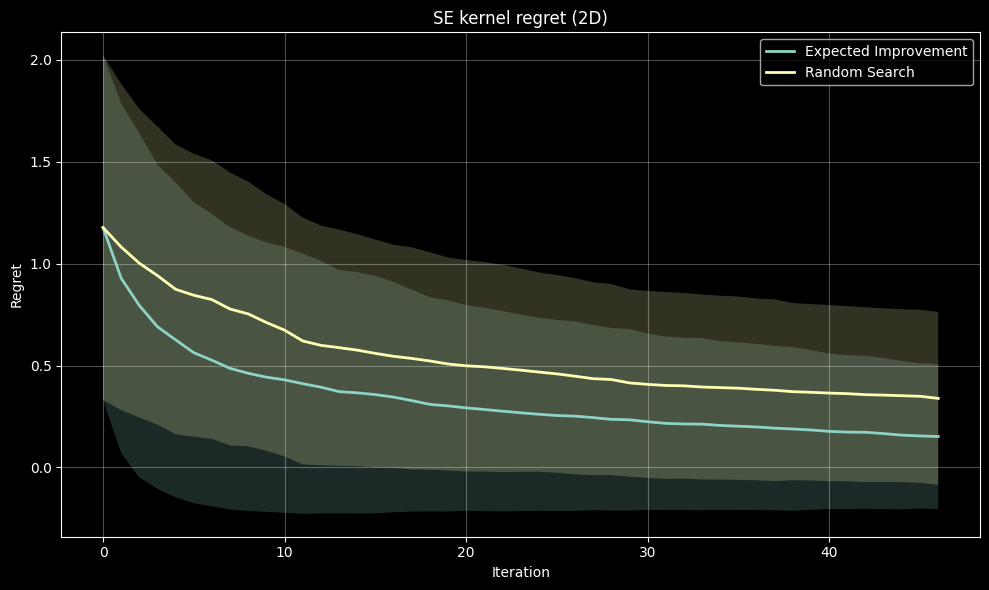

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

acq_funcs = regret_stats.acq_func.unique().tolist()
for method in acq_funcs:
    data = regret_stats[regret_stats['acq_func'] == method]
    ax.plot(data['step'], data['mean'], label=method.replace('_', ' ').title(), linewidth=2)
    ax.fill_between(data['step'],
                    data['mean'] - data['std'],
                    data['mean'] + data['std'],
                    alpha=0.2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Regret')
ax.set_title(f'{KERNEL_TYPE.upper()} kernel regret ({N_DIM}D)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()